# Pulse sequence evaluation

Using arbitrary units. Energy is normalized to the standard deviation in chemical shift strengths. Reduced Planck's constant $\hbar \equiv 1$.

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd
import multiprocessing as mp
import importlib

In [2]:
# default figure size is [6.0, 4.0]
plt.rcParams['figure.figsize'] = [5, 3.33]
# default dpi is 72
plt.rcParams['figure.dpi'] = 144

In [3]:
sys.path.append('..')

In [4]:
import pulse_sequences as ps
import pulse_sequence_data as psd

In [131]:
# importlib.reload(ps)
# importlib.reload(psd)

<module 'pulse_sequence_data' from '../pulse_sequence_data.py'>

## Define system

In [5]:
dipolar_strength = 1e2
pulse_width = 0e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 0e-2
pt_error = 0e-4
N = 4  # number of spins
ensemble_size = 100

In [6]:
X, Y, Z = ps.get_collective_spin(N)

In [7]:
Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength)
                 for _ in range(ensemble_size)]
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=rot_error)
    pt = np.random.normal(scale=pt_error)
    pulses_ensemble.append(ps.get_pulses(H, X, Y, Z, pulse_width, delay,
                                         rot_error=rot, phase_transient=pt))

In [8]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## TMP

In [42]:
tmp = [
    4, 2, 2, 4, 2, 2, 4, 2, 4, 2, 4, 2,
    2, 4, 2, 4, 2, 4, 2, 2, 4, 4, 2, 4,
    4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4,
    4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 4, 4
]

In [43]:
1 - ps.get_mean_fidelity(tmp, Utarget=Utarget, pulses_ensemble=pulses_ensemble)

4.764607841600821e-08

In [9]:
1 - ps.get_mean_fidelity(psd.az_no_err_12, Utarget=Utarget, pulses_ensemble=pulses_ensemble)

0.002299164875811721

In [10]:
1 - ps.get_mean_fidelity(psd.az_no_err_48, Utarget=Utarget, pulses_ensemble=pulses_ensemble)

0.016172223608578506

In [11]:
1 - ps.get_mean_fidelity(psd.cory48, Utarget=Utarget, pulses_ensemble=pulses_ensemble)

4.213723415857906e-06

## Evaluate robustness

Looking at several different sources of errors:

- Non-negligible higher-order terms in Magnus expansion
- Rotation errors
- Phase transients
- Offset errors

### Rotation errors

In [55]:
rot_errors = np.geomspace(1e-4, 1e-1, 10)
rot_errors = np.concatenate([-rot_errors, [0], rot_errors])
rot_errors.sort()

In [56]:
def rot_eval(pulse_sequence, rot_error):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, rot_error=rot_error) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [57]:
def get_rot_data(pulse_sequence, rot_errors, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(rot_eval, [(pulse_sequence, r) for r in rot_errors])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [58]:
cory48_rot_output = get_rot_data(psd.cory48, rot_errors)

np.savez(
    'cory48_rot_output',
    rot_errors=rot_errors,
    cory48=psd.cory48,
    cory48_rot_output=cory48_rot_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [37]:
tmp_rot_output = get_rot_data(tmp, rot_errors)

In [30]:
yxx48_rot_output = get_rot_data(psd.yxx48, rot_errors)

In [66]:
# sequences from 3/6-3/8 jobs
# az12_output = get_rot_data(psd.az12_3, rot_errors)
# az24_output = get_rot_data(osd.az24_2, rot_errors)
# az36_output = get_rot_data(psd.az36, rot_errors)
# az96_output = get_rot_data(psd.az96, rot_errors)

In [74]:
# sequences from 4/16 jobs
az_no_err_12_rot_output = get_rot_data(psd.az_no_err_12, rot_errors)
az_no_err_24_rot_output = get_rot_data(psd.az_no_err_24, rot_errors)
az_no_err_48_rot_output = get_rot_data(psd.az_no_err_48, rot_errors)

np.savez(
    'az_no_err_rot_output',
    rot_errors=rot_errors,
    az_no_err_12=psd.az_no_err_12,
    az_no_err_24=psd.az_no_err_24,
    az_no_err_48=psd.az_no_err_48,
    az_no_err_12_rot_output=az_no_err_12_rot_output[0],
    az_no_err_24_rot_output=az_no_err_24_rot_output[0],
    az_no_err_48_rot_output=az_no_err_48_rot_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [22]:
# sequences from 4/28 jobs
az_rot_err_12_rot_output = get_rot_data(psd.az_rot_err_12, rot_errors)
az_rot_err_24_rot_output = get_rot_data(psd.az_rot_err_24, rot_errors)
az_rot_err_48_rot_output = get_rot_data(psd.az_rot_err_48, rot_errors)

np.savez(
    'az_rot_err_rot_output',
    rot_errors=rot_errors,
    az_rot_err_12=psd.az_rot_err_12,
    az_rot_err_24=psd.az_rot_err_24,
    az_rot_err_48=psd.az_rot_err_48,
    az_rot_err_12_rot_output=az_rot_err_12_rot_output[0],
    az_rot_err_24_rot_output=az_rot_err_24_rot_output[0],
    az_rot_err_48_rot_output=az_rot_err_48_rot_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [9]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_no_err_rot_output.npz')
az_no_err_12_rot_output = dat['az_no_err_12_rot_output']
az_no_err_24_rot_output = dat['az_no_err_24_rot_output']
az_no_err_48_rot_output = dat['az_no_err_48_rot_output']
rot_errors_dat = dat['rot_errors']
# dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_rot_output.npz')
# cory48_rot_output_dat = dat['cory48_rot_output']

In [10]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_rot_err_rot_output.npz')
az_rot_err_12_rot_output = dat['az_rot_err_12_rot_output']
az_rot_err_24_rot_output = dat['az_rot_err_24_rot_output']
az_rot_err_48_rot_output = dat['az_rot_err_48_rot_output']
rot_errors_dat = dat['rot_errors']
# dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_rot_output.npz')
# cory48_rot_output_dat = dat['cory48_rot_output']

In [13]:
dat = np.load('../../data/2021-05/20210506-eval/az_all_err_rot_output.npz')
az_all_err_12_rot_output = dat['az_all_err_12_rot_output']
az_all_err_24_rot_output = dat['az_all_err_24_rot_output']
az_all_err_48_rot_output = dat['az_all_err_48_rot_output']
rot_errors_dat = dat['rot_errors']
dat = np.load('../../data/2021-05/20210506-eval/cory48_rot_output.npz')
cory48_rot_output_dat = dat['cory48_rot_output']

In [59]:
# sequences from 5/2 jobs
az_all_err_12_rot_output = get_rot_data(psd.az_all_err_12, rot_errors)
az_all_err_24_rot_output = get_rot_data(psd.az_all_err_24, rot_errors)
az_all_err_48_rot_output = get_rot_data(psd.az_all_err_48, rot_errors)

np.savez(
    'az_all_err_rot_output',
    rot_errors=rot_errors,
    az_all_err_12=psd.az_all_err_12,
    az_all_err_24=psd.az_all_err_24,
    az_all_err_48=psd.az_all_err_48,
    az_all_err_12_rot_output=az_all_err_12_rot_output[0],
    az_all_err_24_rot_output=az_all_err_24_rot_output[0],
    az_all_err_48_rot_output=az_all_err_48_rot_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [31]:
# best 48-pulse sequence so far, from 3/4
az48_rot_output = get_rot_data(psd.az48_3, rot_errors)

In [32]:
# az 48-pulse sequence from 4/3
az48_2_rot_output = get_rot_data(psd.az48_5, rot_errors)

### Load previous data

In [14]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_no_err_rot_output.npz')
az_no_err_12_rot_output = dat['az_no_err_12_rot_output']
az_no_err_24_rot_output = dat['az_no_err_24_rot_output']
az_no_err_48_rot_output = dat['az_no_err_48_rot_output']
rot_errors_dat = dat['rot_errors']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_rot_output.npz')
cory48_rot_output_dat = dat['cory48_rot_output']

In [18]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_rot_err_rot_output.npz')
az_rot_err_12_rot_output = dat['az_rot_err_12_rot_output']
az_rot_err_24_rot_output = dat['az_rot_err_24_rot_output']
az_rot_err_48_rot_output = dat['az_rot_err_48_rot_output']
rot_errors_dat = dat['rot_errors']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_rot_output.npz')
cory48_rot_output_dat = dat['cory48_rot_output']

In [21]:
dat = np.load('../../data/2021-05/20210506-eval/az_all_err_rot_output.npz')
az_all_err_12_rot_output = dat['az_all_err_12_rot_output']
az_all_err_24_rot_output = dat['az_all_err_24_rot_output']
az_all_err_48_rot_output = dat['az_all_err_48_rot_output']
rot_errors_dat = dat['rot_errors']
dat = np.load('../../data/2021-05/20210506-eval/cory48_rot_output.npz')
cory48_rot_output_dat = dat['cory48_rot_output']

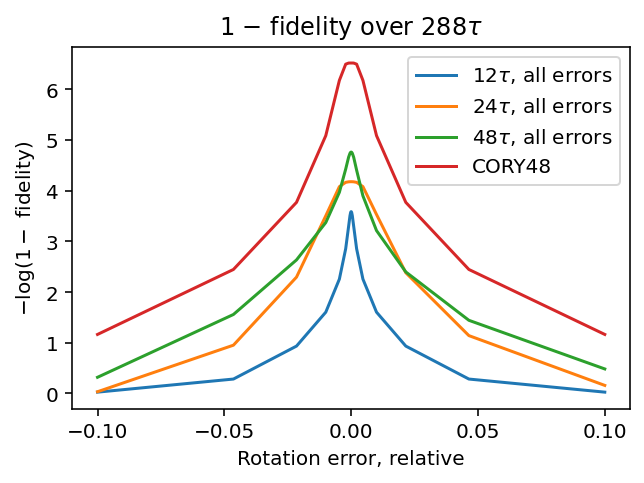

In [25]:
# # no errors
# plt.plot(rot_errors_dat, -np.log10(1-az_no_err_12_rot_output), label=r'12$\tau$, no errors')
# plt.plot(rot_errors_dat, -np.log10(1-az_no_err_24_rot_output), label=r'24$\tau$, no errors')
# plt.plot(rot_errors_dat, -np.log10(1-az_no_err_48_rot_output), label=r'48$\tau$, no errors')

# # rotation errors
# plt.plot(rot_errors_dat, -np.log10(1-az_rot_err_12_rot_output), label=r'12$\tau$, rotation errors')
# plt.plot(rot_errors_dat, -np.log10(1-az_rot_err_24_rot_output), label=r'24$\tau$, rotation errors')
# plt.plot(rot_errors_dat, -np.log10(1-az_rot_err_48_rot_output), label=r'48$\tau$, rotation errors')

# all errors
plt.plot(rot_errors_dat, -np.log10(1-az_all_err_12_rot_output), label=r'12$\tau$, all errors')
plt.plot(rot_errors_dat, -np.log10(1-az_all_err_24_rot_output), label=r'24$\tau$, all errors')
plt.plot(rot_errors_dat, -np.log10(1-az_all_err_48_rot_output), label=r'48$\tau$, all errors')

# plt.plot(rot_errors, -np.log10(1-cory48_rot_output[0]), label='CORY48')
plt.plot(rot_errors_dat, -np.log10(1-cory48_rot_output_dat), label='CORY48')

# plt.vlines(0, 10**-9, 10**-2, 'k')
plt.title(r'1 $-$ fidelity over 288$\tau$')
plt.xlabel('Rotation error, relative')
plt.ylabel(r'$-\log(1 -$ fidelity$)$')
plt.xticks(ticks=np.linspace(-.1, .1, 5))
# plt.xscale('symlog', linthresh=1e-2)
# plt.vlines([-2e-3, 2e-3], [1e-8]*2, [1e-1]*2, 'black', 'dotted')
# plt.yscale('log')
plt.legend()
plt.savefig('rot_errors.pdf', bbox_inches='tight')

### Phase transients

In [61]:
phase_transients = np.geomspace(1e-5, 1e-2, 20)  # 20
phase_transients = np.concatenate([[0], phase_transients])
phase_transients.sort()

In [33]:
def pt_eval(pulse_sequence, pt):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay, phase_transient=pt) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [34]:
def get_pt_data(pulse_sequence, phase_transients, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(pt_eval, [(pulse_sequence, r) for r in phase_transients])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [62]:
cory48_pt_output = get_pt_data(psd.cory48, phase_transients)

np.savez(
    'cory48_pt_output',
    phase_transients=phase_transients,
    cory48=psd.cory48,
    cory48_pt_output=cory48_pt_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [38]:
yxx48_pt_output = get_pt_data(psd.yxx48, phase_transients)

In [57]:
# az12_pt_output = get_pt_data(psd.az12_3, phase_transients)
# az24_pt_output = get_pt_data(psd.az24_2, phase_transients)
# az36_pt_output = get_pt_data(psd.az36, phase_transients)
# az96_pt_output = get_pt_data(psd.az96, phase_transients)

In [88]:
# 4/16, trained on no errors
az_no_err_12_pt_output = get_pt_data(psd.az_no_err_12, phase_transients)
az_no_err_24_pt_output = get_pt_data(psd.az_no_err_24, phase_transients)
az_no_err_48_pt_output = get_pt_data(psd.az_no_err_48, phase_transients)

np.savez(
    'az_no_err_pt_output',
    phase_transients=phase_transients,
    az_no_err_12=psd.az_no_err_12,
    az_no_err_24=psd.az_no_err_24,
    az_no_err_48=psd.az_no_err_48,
    az_no_err_12_pt_output=az_no_err_12_pt_output[0],
    az_no_err_24_pt_output=az_no_err_24_pt_output[0],
    az_no_err_48_pt_output=az_no_err_48_pt_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [145]:
# 4/28, trained on rotation errors
az_rot_err_12_pt_output = get_pt_data(psd.az_rot_err_12, phase_transients)
az_rot_err_24_pt_output = get_pt_data(psd.az_rot_err_24, phase_transients)
az_rot_err_48_pt_output = get_pt_data(psd.az_rot_err_48, phase_transients)

np.savez(
    'az_rot_err_pt_output',
    phase_transients=phase_transients,
    az_rot_err_12=psd.az_rot_err_12,
    az_rot_err_24=psd.az_rot_err_24,
    az_rot_err_48=psd.az_rot_err_48,
    az_rot_err_12_pt_output=az_rot_err_12_pt_output[0],
    az_rot_err_24_pt_output=az_rot_err_24_pt_output[0],
    az_rot_err_48_pt_output=az_rot_err_48_pt_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [63]:
# 5/2, trained on rotation errors
az_all_err_12_pt_output = get_pt_data(psd.az_all_err_12, phase_transients)
az_all_err_24_pt_output = get_pt_data(psd.az_all_err_24, phase_transients)
az_all_err_48_pt_output = get_pt_data(psd.az_all_err_48, phase_transients)

np.savez(
    'az_all_err_pt_output',
    phase_transients=phase_transients,
    az_all_err_12=psd.az_all_err_12,
    az_all_err_24=psd.az_all_err_24,
    az_all_err_48=psd.az_all_err_48,
    az_all_err_12_pt_output=az_all_err_12_pt_output[0],
    az_all_err_24_pt_output=az_all_err_24_pt_output[0],
    az_all_err_48_pt_output=az_all_err_48_pt_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [41]:
# from 3/15-??? jobs
# unconstrained 12 pulse sequence
az12_unc_pt_output = get_pt_data(psd.az12_unconstrained, phase_transients)
# unconstrained 24 pulse sequence
az24_unc_pt_output = get_pt_data(psd.az24_unconstrained_2, phase_transients)
az36_unc_pt_output = get_pt_data(psd.az36_unconstrained, phase_transients)
az48_unc_pt_output = get_pt_data(psd.az48_unconstrained_2, phase_transients)

In [39]:
az48_pt_output = get_pt_data(psd.az48_3, phase_transients)

In [40]:
az48_2_pt_output = get_pt_data(psd.az48_5, phase_transients)

In [28]:
az48_robust_pt_output = get_pt_data(tmp, phase_transients)

In [26]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_no_err_pt_output.npz')
az_no_err_12_pt_output = dat['az_no_err_12_pt_output']
az_no_err_24_pt_output = dat['az_no_err_24_pt_output']
az_no_err_48_pt_output = dat['az_no_err_48_pt_output']
phase_transients_dat = dat['phase_transients']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_pt_output.npz')
cory48_pt_output_dat = dat['cory48_pt_output']

In [27]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_rot_err_pt_output.npz')
az_rot_err_12_pt_output = dat['az_rot_err_12_pt_output']
az_rot_err_24_pt_output = dat['az_rot_err_24_pt_output']
az_rot_err_48_pt_output = dat['az_rot_err_48_pt_output']
phase_transients_dat = dat['phase_transients']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_pt_output.npz')
cory48_pt_output_dat = dat['cory48_pt_output']

In [62]:
dat = np.load('../../data/2021-05/20210506-eval/az_all_err_pt_output.npz')
az_all_err_12_pt_output = dat['az_all_err_12_pt_output']
az_all_err_24_pt_output = dat['az_all_err_24_pt_output']
az_all_err_48_pt_output = dat['az_all_err_48_pt_output']
phase_transients_dat = dat['phase_transients']
dat = np.load('../../data/2021-05/20210506-eval/cory48_pt_output.npz')
cory48_pt_output_dat = dat['cory48_pt_output']

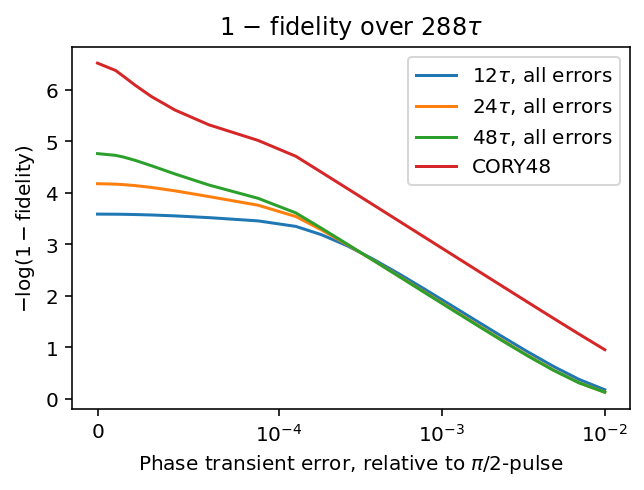

In [32]:
# # 4/16
# plt.plot(phase_transients_dat, -np.log10(1-az_no_err_12_pt_output), label=r'12$\tau$, no errors')
# plt.plot(phase_transients_dat, -np.log10(1-az_no_err_24_pt_output), label=r'24$\tau$, no errors')
# plt.plot(phase_transients_dat, -np.log10(1-az_no_err_48_pt_output), label=r'48$\tau$, no errors')

# rotation errors
# plt.plot(phase_transients_dat, -np.log10(1-az_rot_err_12_pt_output), label=r'12$\tau$, rotation errors')
# plt.plot(phase_transients_dat, -np.log10(1-az_rot_err_24_pt_output), label=r'24$\tau$, rotation errors')
# plt.plot(phase_transients_dat, -np.log10(1-az_rot_err_48_pt_output), label=r'48$\tau$, rotation errors')

# all errors
plt.plot(phase_transients_dat, -np.log10(1-az_all_err_12_pt_output), label=r'12$\tau$, all errors')
plt.plot(phase_transients_dat, -np.log10(1-az_all_err_24_pt_output), label=r'24$\tau$, all errors')
plt.plot(phase_transients_dat, -np.log10(1-az_all_err_48_pt_output), label=r'48$\tau$, all errors')

# plt.plot(phase_transients, -np.log10(1-cory48_pt_output[0]), label='CORY48')
plt.plot(phase_transients_dat, -np.log10(1-cory48_pt_output_dat), label='CORY48')
# plt.plot(phase_transients, 1-yxx48_pt_output[0], label='yxx48')

# plt.plot(phase_transients, 1-az48_robust_pt_output[0], label='az48/AHT robust')

plt.title(r'1 $-$ fidelity over 288$\tau$')
plt.xscale('symlog', linthresh=1e-4)
# plt.yscale('log')
plt.xlabel(r'Phase transient error, relative to $\pi/2$-pulse')
plt.ylabel('$-\log(1 - $fidelity$)$')
plt.legend()
plt.savefig('phase_transients.pdf', bbox_inches='tight')

### Delay timings

In [59]:
taus = np.geomspace(1e-5, 1e-3, 20)
# taus = np.concatenate([[0], taus])
taus.sort()

In [60]:
def delay_eval(pulse_sequence, tau):
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width, delay=tau) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [61]:
def get_tau_data(pulse_sequence, taus, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(delay_eval, [(pulse_sequence, r) for r in taus])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [69]:
cory48_tau_output = get_tau_data(psd.cory48, taus)

np.savez(
    'cory48_tau_output',
    taus=taus,
    cory48=psd.cory48,
    cory48_tau_output=cory48_tau_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [46]:
yxx48_tau_output = get_tau_data(psd.yxx48, taus)

In [110]:
az_no_err_12_tau_output = get_tau_data(psd.az_no_err_12, taus)
az_no_err_24_tau_output = get_tau_data(psd.az_no_err_24, taus)
az_no_err_48_tau_output = get_tau_data(psd.az_no_err_48, taus)

np.savez(
    'az_no_err_tau_output',
    taus=taus,
    az_no_err_12=psd.az_no_err_12,
    az_no_err_24=psd.az_no_err_24,
    az_no_err_48=psd.az_no_err_48,
    az_no_err_12_tau_output=az_no_err_12_tau_output[0],
    az_no_err_24_tau_output=az_no_err_24_tau_output[0],
    az_no_err_48_tau_output=az_no_err_48_tau_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [149]:
# 4/28, trained on rotation errors
az_rot_err_12_tau_output = get_tau_data(psd.az_rot_err_12, taus)
az_rot_err_24_tau_output = get_tau_data(psd.az_rot_err_24, taus)
az_rot_err_48_tau_output = get_tau_data(psd.az_rot_err_48, taus)

np.savez(
    'az_rot_err_tau_output',
    taus=taus,
    az_rot_err_12=psd.az_rot_err_12,
    az_rot_err_24=psd.az_rot_err_24,
    az_rot_err_48=psd.az_rot_err_48,
    az_rot_err_12_tau_output=az_rot_err_12_tau_output[0],
    az_rot_err_24_tau_output=az_rot_err_24_tau_output[0],
    az_rot_err_48_tau_output=az_rot_err_48_tau_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [66]:
# 5/2, trained on all errors
az_all_err_12_tau_output = get_tau_data(psd.az_all_err_12, taus)
az_all_err_24_tau_output = get_tau_data(psd.az_all_err_24, taus)
az_all_err_48_tau_output = get_tau_data(psd.az_all_err_48, taus)

np.savez(
    'az_all_err_tau_output',
    taus=taus,
    az_all_err_12=psd.az_all_err_12,
    az_all_err_24=psd.az_all_err_24,
    az_all_err_48=psd.az_all_err_48,
    az_all_err_12_tau_output=az_all_err_12_tau_output[0],
    az_all_err_24_tau_output=az_all_err_24_tau_output[0],
    az_all_err_48_tau_output=az_all_err_48_tau_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [124]:
# from 3/15-??? jobs
# unconstrained 12 pulse sequence
az12_unc_tau_output = get_tau_data(psd.az12_unconstrained, taus)
# unconstrained 24 pulse sequence
az24_unc_tau_output = get_tau_data(psd.az24_unconstrained_2, taus)
az36_unc_tau_output = get_tau_data(psd.az36_unconstrained, taus)
az48_unc_tau_output = get_tau_data(psd.az48_unconstrained_2, taus)

In [47]:
az48_tau_output = get_tau_data(psd.az48_3, taus)

In [48]:
az48_2_tau_output = get_tau_data(psd.az48_5, taus)

In [52]:
# az48_robust_tau_output = get_tau_data(psd.az48_robust, taus)

### Load saved data for tau delays

In [52]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_no_err_tau_output.npz')
az_no_err_12_tau_output = dat['az_no_err_12_tau_output']
az_no_err_24_tau_output = dat['az_no_err_24_tau_output']
az_no_err_48_tau_output = dat['az_no_err_48_tau_output']
taus = dat['taus']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_tau_output.npz')
cory48_tau_output = dat['cory48_tau_output']

In [53]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_rot_err_tau_output.npz')
az_rot_err_12_tau_output = dat['az_rot_err_12_tau_output']
az_rot_err_24_tau_output = dat['az_rot_err_24_tau_output']
az_rot_err_48_tau_output = dat['az_rot_err_48_tau_output']
taus = dat['taus']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_tau_output.npz')
cory48_tau_output = dat['cory48_tau_output']

In [75]:
dat = np.load('../../data/2021-05/20210506-eval/az_all_err_tau_output.npz')
az_all_err_12_tau_output = dat['az_all_err_12_tau_output']
az_all_err_24_tau_output = dat['az_all_err_24_tau_output']
az_all_err_48_tau_output = dat['az_all_err_48_tau_output']
taus = dat['taus']
dat = np.load('../../data/2021-05/20210506-eval/cory48_tau_output.npz')
cory48_tau_output = dat['cory48_tau_output']

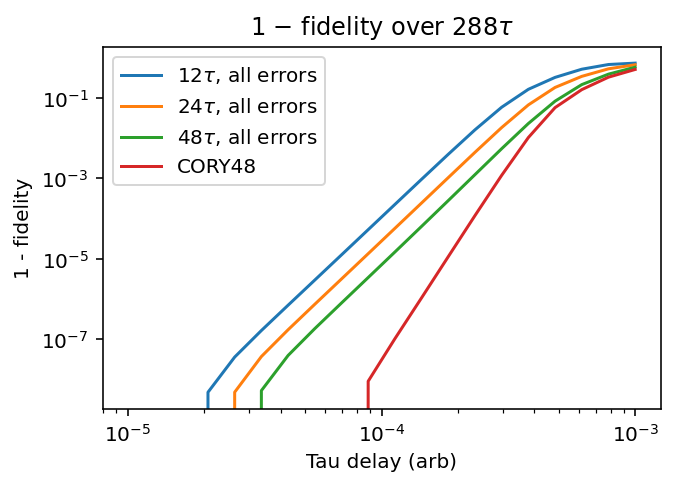

In [76]:
# # 4/16
# plt.plot(taus, 1-az_no_err_12_tau_output, label=r'12$\tau$, no errors')
# plt.plot(taus, 1-az_no_err_24_tau_output, label=r'24$\tau$, no errors')
# plt.plot(taus, 1-az_no_err_48_tau_output, label=r'48$\tau$, no errors')

# 4/28
# plt.plot(taus, 1-az_rot_err_12_tau_output, label=r'12$\tau$, rotation errors')
# plt.plot(taus, 1-az_rot_err_24_tau_output, label=r'24$\tau$, rotation errors')
# plt.plot(taus, 1-az_rot_err_48_tau_output, label=r'48$\tau$, rotation errors')

# 5/2
plt.plot(taus, 1-az_all_err_12_tau_output, label=r'12$\tau$, all errors')
plt.plot(taus, 1-az_all_err_24_tau_output, label=r'24$\tau$, all errors')
plt.plot(taus, 1-az_all_err_48_tau_output, label=r'48$\tau$, all errors')

plt.plot(taus, 1-cory48_tau_output, label='CORY48')

# plt.plot(taus, 1-az48_robust_tau_output[0], label='az48/AHT robust')

plt.title(r'1 $-$ fidelity over 288$\tau$')
# plt.xscale('symlog', linthresh=1e-4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Tau delay (arb)')
plt.ylabel('1 - fidelity')
plt.legend()
plt.savefig('tau_delay.pdf', bbox_inches='tight')

### Offset errors

In [104]:
offsets = np.geomspace(1e-1, 1e2, 10)
offsets = np.concatenate([-offsets, [0], offsets])
offsets.sort()

In [66]:
def offset_eval(pulse_sequence, offset):
    Hsys_ensemble = [ps.get_Hsys(N, dipolar_strength=dipolar_strength, offset=offset)
                     for _ in range(ensemble_size)]
    pe = [ps.get_pulses(H, X, Y, Z, pulse_width=pulse_width, delay=delay) for H in Hsys_ensemble]
    U_ensemble = [ps.get_propagator(pulse_sequence, p) for p in pe]
    U_ensemble_full = []
    for U in U_ensemble:
        U_full = qt.identity(U.dims[0])
        for _ in range(int(288/len(pulse_sequence))):
            U_full = U * U_full
        U_ensemble_full.append(U_full)
    fidelities = np.array([qt.metrics.average_gate_fidelity(U, Utarget)
                           for U in U_ensemble_full])
    return np.mean(fidelities), np.std(fidelities)

In [67]:
def get_offset_data(pulse_sequence, offsets, num_workers=4):
    with mp.Pool(num_workers) as p:
        output = p.starmap(offset_eval, [(pulse_sequence, r) for r in offsets])
    
    fidelity, fidelity_std = zip(*output)
    fidelity = np.array(fidelity)
    fidelity_std = np.array(fidelity_std)
    
    return fidelity, fidelity_std

In [68]:
cory48_offset_output = get_offset_data(psd.cory48, offsets)

np.savez(
    'cory48_offset_output',
    offsets=offsets,
    cory48=psd.cory48,
    cory48_offset_output=cory48_offset_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [121]:
az_no_err_12_offset_output = get_offset_data(psd.az_no_err_12, offsets)
az_no_err_24_offset_output = get_offset_data(psd.az_no_err_24, offsets)
az_no_err_48_offset_output = get_offset_data(psd.az_no_err_48, offsets)

np.savez(
    'az_no_err_offset_output',
    offsets=offsets,
    az_no_err_12=psd.az_no_err_12,
    az_no_err_24=psd.az_no_err_24,
    az_no_err_48=psd.az_no_err_48,
    az_no_err_12_offset_output=az_no_err_12_offset_output[0],
    az_no_err_24_offset_output=az_no_err_24_offset_output[0],
    az_no_err_48_offset_output=az_no_err_48_offset_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [175]:
# 4/28, trained on rotation errors
az_rot_err_12_offset_output = get_offset_data(psd.az_rot_err_12, offsets)
az_rot_err_24_offset_output = get_offset_data(psd.az_rot_err_24, offsets)
az_rot_err_48_offset_output = get_offset_data(psd.az_rot_err_48, offsets)

np.savez(
    'az_rot_err_offset_output',
    offsets=offsets,
    az_rot_err_12=psd.az_rot_err_12,
    az_rot_err_24=psd.az_rot_err_24,
    az_rot_err_48=psd.az_rot_err_48,
    az_rot_err_12_offset_output=az_rot_err_12_offset_output[0],
    az_rot_err_24_offset_output=az_rot_err_24_offset_output[0],
    az_rot_err_48_offset_output=az_rot_err_48_offset_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [69]:
# 5/2, trained on all errors
az_all_err_12_offset_output = get_offset_data(psd.az_all_err_12, offsets)
az_all_err_24_offset_output = get_offset_data(psd.az_all_err_24, offsets)
az_all_err_48_offset_output = get_offset_data(psd.az_all_err_48, offsets)

np.savez(
    'az_all_err_offset_output',
    offsets=offsets,
    az_all_err_12=psd.az_all_err_12,
    az_all_err_24=psd.az_all_err_24,
    az_all_err_48=psd.az_all_err_48,
    az_all_err_12_offset_output=az_all_err_12_offset_output[0],
    az_all_err_24_offset_output=az_all_err_24_offset_output[0],
    az_all_err_48_offset_output=az_all_err_48_offset_output[0],
    dipolar_strength=dipolar_strength,
    pulse_width=pulse_width,
    delay=delay,
    rot_error=rot_error,
    N=N,
    ensemble_size=ensemble_size,
)

In [34]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_no_err_offset_output.npz')
az_no_err_12_offset_output = dat['az_no_err_12_offset_output']
az_no_err_24_offset_output = dat['az_no_err_24_offset_output']
az_no_err_48_offset_output = dat['az_no_err_48_offset_output']
offsets_dat = dat['offsets']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_offset_output.npz')
cory48_offset_output_dat = dat['cory48_offset_output']

In [35]:
dat = np.load('../../data/2021-04/20210430-eval/no_errors/az_rot_err_offset_output.npz')
az_rot_err_12_offset_output = dat['az_rot_err_12_offset_output']
az_rot_err_24_offset_output = dat['az_rot_err_24_offset_output']
az_rot_err_48_offset_output = dat['az_rot_err_48_offset_output']
offsets_dat = dat['offsets']
dat = np.load('../../data/2021-04/20210430-eval/no_errors/cory48_offset_output.npz')
cory48_offset_output_dat = dat['cory48_offset_output']

In [41]:
dat = np.load('../../data/2021-05/20210506-eval/az_all_err_offset_output.npz')
az_all_err_12_offset_output = dat['az_all_err_12_offset_output']
az_all_err_24_offset_output = dat['az_all_err_24_offset_output']
az_all_err_48_offset_output = dat['az_all_err_48_offset_output']
offsets_dat = dat['offsets']
dat = np.load('../../data/2021-05/20210506-eval/cory48_offset_output.npz')
cory48_offset_output_dat = dat['cory48_offset_output']

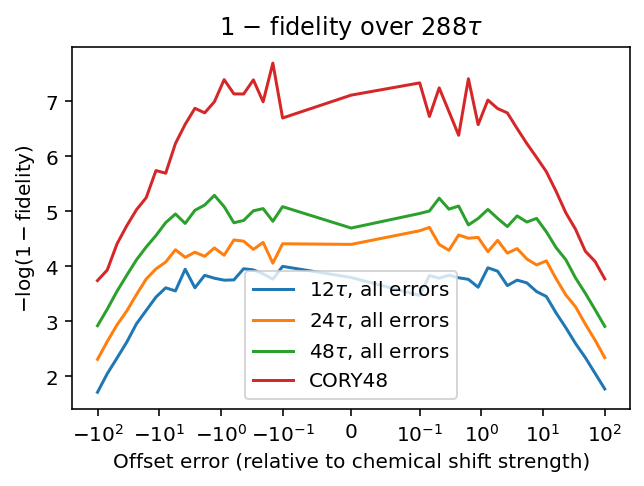

In [42]:
# # 4/16
# plt.plot(offsets_dat, -np.log10(1-az_no_err_12_offset_output), label=r'12$\tau$, no errors')
# plt.plot(offsets_dat, -np.log10(1-az_no_err_24_offset_output), label=r'24$\tau$, no errors')
# plt.plot(offsets_dat, -np.log10(1-az_no_err_48_offset_output), label=r'48$\tau$, no errors')

# 4/28
# plt.plot(offsets_dat, -np.log10(1-az_rot_err_12_offset_output), label=r'12$\tau$, rotation errors')
# plt.plot(offsets_dat, -np.log10(1-az_rot_err_24_offset_output), label=r'24$\tau$, rotation errors')
# plt.plot(offsets_dat, -np.log10(1-az_rot_err_48_offset_output), label=r'48$\tau$, rotation errors')

# 5/2
plt.plot(offsets_dat, -np.log10(1-az_all_err_12_offset_output), label=r'12$\tau$, all errors')
plt.plot(offsets_dat, -np.log10(1-az_all_err_24_offset_output), label=r'24$\tau$, all errors')
plt.plot(offsets_dat, -np.log10(1-az_all_err_48_offset_output), label=r'48$\tau$, all errors')

# plt.plot(offsets, -np.log10(1-cory48_offset_output[0]), label='CORY48')
plt.plot(offsets_dat, -np.log10(1-cory48_offset_output_dat), label='CORY48')

plt.title(r'1 $-$ fidelity over 288$\tau$')
# plt.xscale('symlog', linthresh=1e-4)
plt.xscale('symlog', linthresh=1e-1)
# plt.yscale('log')
plt.xlabel(r'Offset error (relative to chemical shift strength)')
plt.ylabel(r'$-\log(1 - $fidelity$)$')
plt.legend()
plt.savefig('offset_errors.pdf', bbox_inches='tight')

## Evaluate performance by pulse sequence length

In [56]:
cory48_output = get_rot_data(psd.cory48, [0])
yxx48_output = get_rot_data(psd.yxx48, [0])

In [54]:
# from 3/15-17 jobs
# unconstrained 12 pulse sequence
az12_unc_output = get_rot_data(psd.az12_unconstrained, [0])
# unconstrained 24 pulse sequence
az24_unc_output = get_rot_data(psd.az24_unconstrained_2, [0])
az36_unc_output = get_rot_data(psd.az36_unconstrained, [0])
az48_unc_output = get_rot_data(psd.az48_unconstrained_2, [0])

In [69]:
az48_output = get_rot_data(psd.az48_3, [0])

In [70]:
az48_output

(array([0.99997426]), array([3.79972546e-05]))

In [60]:
outputs = [az12_unc_output, az24_unc_output, az36_unc_output, az48_unc_output]

In [61]:
outputs

[(array([0.99933607]), array([0.00036743])),
 (array([0.99024145]), array([0.00752147])),
 (array([0.9878416]), array([0.00966425])),
 (array([0.99433953]), array([0.00439748]))]

In [62]:
fid_means = np.array([_[0] for _ in outputs])

In [63]:
fid_means

array([[0.99933607],
       [0.99024145],
       [0.9878416 ],
       [0.99433953]])

Fidelities are corrected for differences in pulse sequence length.

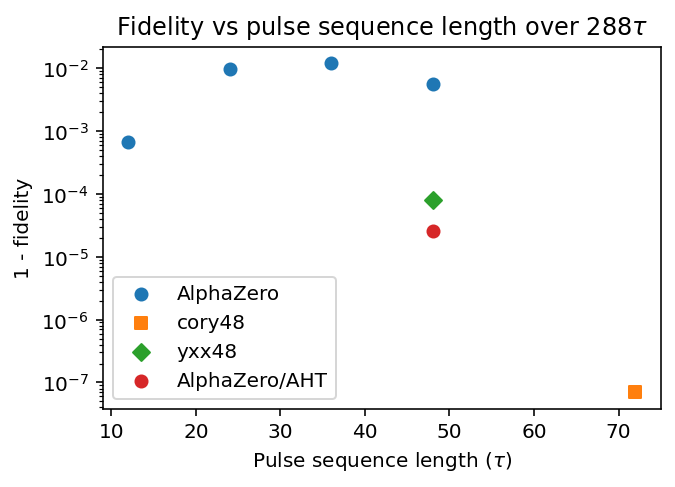

In [130]:
plt.scatter([12, 24, 36, 48], 1 - fid_means, label='AlphaZero')
plt.scatter([72], 1 - cory48_output[0], label='cory48', marker='s')
plt.scatter([48], 1 - yxx48_output[0], label='yxx48', marker='D')

plt.scatter([48], 1 - az48_output[0], label='AlphaZero/AHT')

plt.legend()
plt.yscale('log')
plt.xlabel(r'Pulse sequence length ($\tau$)')
plt.ylabel('1 - fidelity')
plt.title(r'Fidelity vs pulse sequence length over 288$\tau$')
plt.savefig('pulse-sequence-length.pdf', bbox_inches='tight')